In [1]:
#Imports
import re
import unicodedata
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import acquire as ac
import prepare as pr
import env

## 1. Spam Data

a. Load the spam data set.

b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

c. Is there any overlap in the bigrams for the spam data and the ham data?

d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [2]:
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url)
df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#Clean the text data by label
ham_words = clean_text(' '.join(df[df['label'] == 'ham']['text']))
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))
all_words = clean_text(' '.join(df['text']))

In [5]:
#Save the value counts of each series to a variable
ham_counts = pd.Series(ham_words).value_counts()
spam_counts = pd.Series(spam_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [6]:
word_freq = pd.concat([ham_counts, spam_counts, all_counts], axis=1)
word_freq.head()

,count,count,count
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [7]:
#Check for nulls
word_freq.isna().sum()

count    1918
count    6086
count       0
dtype: int64

In [8]:
#Rename columns and fill null values
word_freq.columns = ['ham', 'spam', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279


In [9]:
#Check datatypes of columns
word_freq.dtypes

ham     float64
spam    float64
all       int64
dtype: object

In [10]:
#Recast all columns as integers
word_freq = word_freq.astype('int')
word_freq.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [11]:
#Calculate percentage of all words by label
word_freq['pct_ham'] = word_freq['ham'] / word_freq['all'] * 100
word_freq['pct_spam'] = word_freq['spam'] / word_freq['all'] * 100
word_freq.head()

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
go,273,31,304,89.802632,10.197368
ok,272,5,277,98.194946,1.805054
dont,257,22,279,92.114695,7.885305


In [12]:
word_freq[word_freq['spam'] > 100].sort_values('pct_spam', ascending=False)


,ham,spam,all,pct_ham,pct_spam
claim,0,115,115,0.000000,100.000000
txt,13,150,163,7.975460,92.024540
mobile,15,135,150,10.000000,90.000000
free,59,216,275,21.454545,78.545455
stop,40,113,153,26.143791,73.856209
reply,43,102,145,29.655172,70.344828
text,77,137,214,35.981308,64.018692
call,241,359,600,40.166667,59.833333
4,168,119,287,58.536585,41.463415
ur,240,144,384,62.500000,37.500000


In [13]:
ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))
ham_bigrams.head(10)

0          (go, jurong)
1       (jurong, point)
2        (point, crazy)
3    (crazy, available)
4    (available, bugis)
5            (bugis, n)
6            (n, great)
7        (great, world)
8           (world, la)
9               (la, e)
dtype: object

In [14]:
top_ham_bigrams = ham_bigrams.value_counts().head(10)
top_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(ok, lor)          22
Name: count, dtype: int64

In [15]:
spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2))
spam_bigrams.head(10)

0    (free, entry)
1    (entry, wkly)
2     (wkly, comp)
3      (comp, win)
4        (win, fa)
5        (fa, cup)
6     (cup, final)
7    (final, tkts)
8     (tkts, 21st)
9      (21st, may)
dtype: object

In [16]:
top_spam_bigrams = spam_bigrams.value_counts().head(10)
top_spam_bigrams

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
(prize, guaranteed)    22
(send, stop)           19
(selected, receive)    19
(await, collection)    19
(every, week)          19
Name: count, dtype: int64

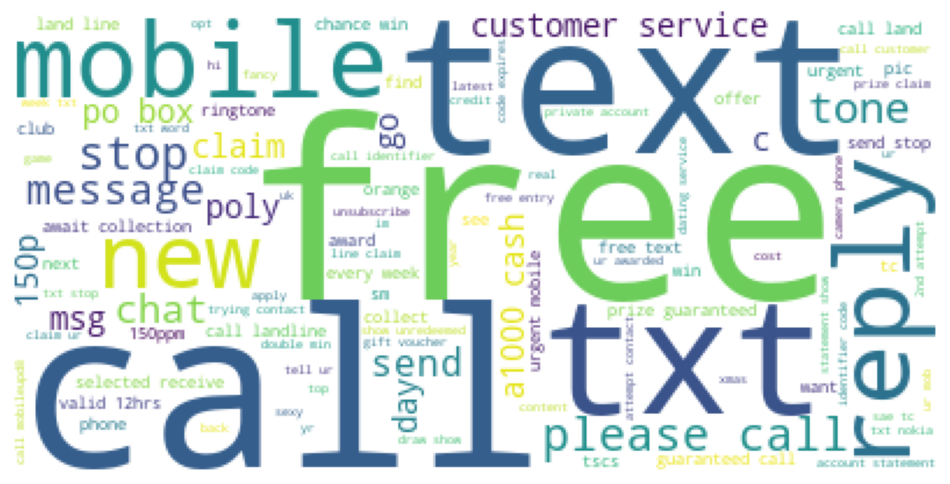

In [17]:
#Word cloud
all_cloud1 = WordCloud(background_color='white').generate(' '.join(spam_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud1)
plt.axis('off')
plt.show()

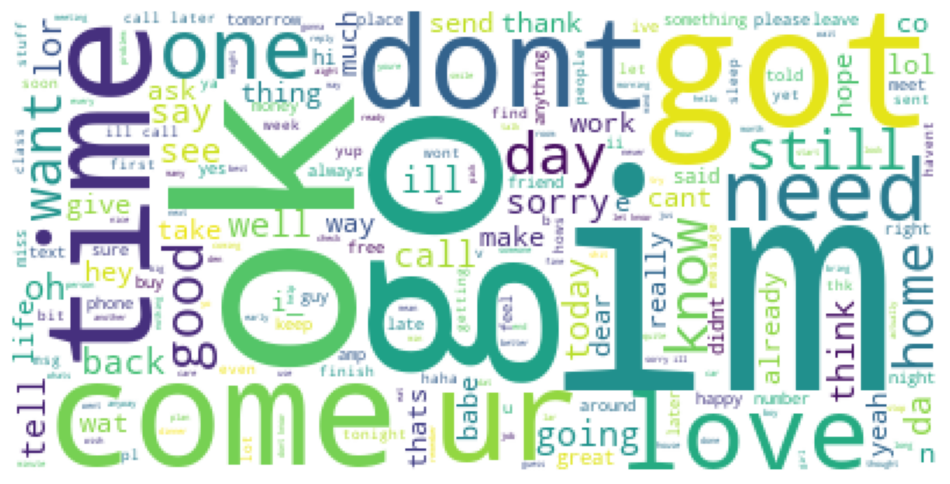

In [18]:
#Word cloud
all_cloud2 = WordCloud(background_color='white').generate(' '.join(ham_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud2)
plt.axis('off')
plt.show()

c. 

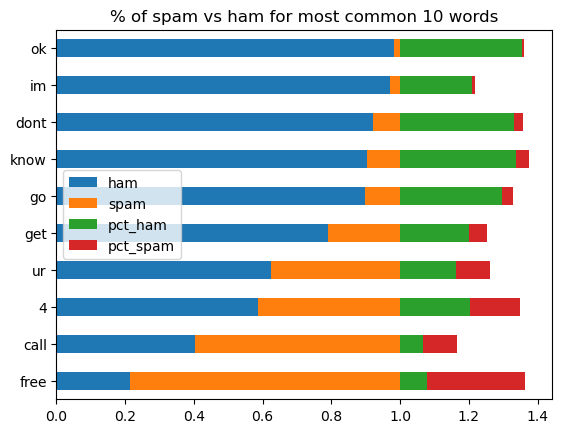

In [19]:
#visualize only ham and spam as percent of 'all'
(word_freq.sort_values(by='all', ascending=False)
 .head(10)
 .apply(lambda row: row/ row['all'],axis=1)
 .drop(columns='all')
 .sort_values(by='spam')
 .plot.barh(stacked=True)).invert_yaxis()
plt.title('% of spam vs ham for most common 10 words')
None

d. 

In [20]:
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3))
ham_trigrams.head(10)

0          (go, jurong, point)
1       (jurong, point, crazy)
2    (point, crazy, available)
3    (crazy, available, bugis)
4        (available, bugis, n)
5            (bugis, n, great)
6            (n, great, world)
7           (great, world, la)
8               (world, la, e)
9              (la, e, buffet)
dtype: object

In [21]:
top_ham_trigrams = ham_trigrams.value_counts().head(10)
top_ham_trigrams

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
(right, pls, send)      12
(phone, right, pls)     12
(pick, phone, right)    12
(hi, hi, hi)            11
(x, x, x)                8
Name: count, dtype: int64

In [22]:
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3))
spam_trigrams.head(10)

0    (free, entry, wkly)
1    (entry, wkly, comp)
2      (wkly, comp, win)
3        (comp, win, fa)
4         (win, fa, cup)
5       (fa, cup, final)
6     (cup, final, tkts)
7    (final, tkts, 21st)
8      (tkts, 21st, may)
9      (21st, may, 2005)
dtype: object

In [23]:
top_spam_trigrams = spam_trigrams.value_counts().head(10)
top_spam_trigrams

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
(2003, account, statement)    13
(camcorder, reply, call)      12
(guaranteed, a1000, cash)     12
(show, 800, unredeemed)       12
(urgent, trying, contact)     11
Name: count, dtype: int64

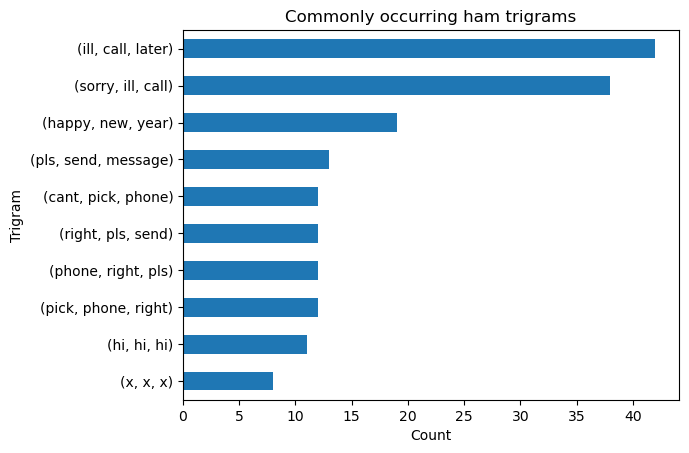

In [24]:
#Plot
top_ham_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring ham trigrams')
plt.show()

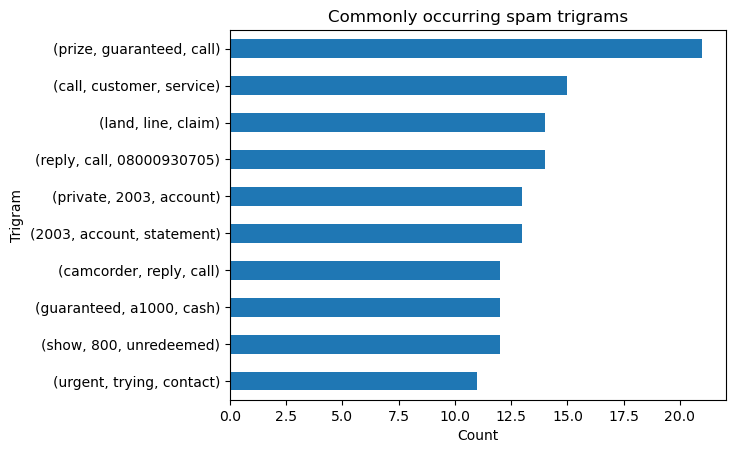

In [25]:
#Plot
top_spam_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.title('Commonly occurring spam trigrams')
plt.show()

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.



In [26]:
codeup_df = pd.DataFrame(ac.get_blog_articles('blog_posts.json'))

codeup_df.head()

,title,link,date_published,content
0,Women in tech: Panelist Spotlight – Magdalena ...,https://codeup.com/events/black-excellence-in-...,"Mar 28, 2023",\nWomen in tech: Panelist Spotlight – Magdalen...
1,Women in tech: Panelist Spotlight – Rachel Rob...,https://codeup.com/events/black-excellence-in-...,"Mar 20, 2023",\nWomen in tech: Panelist Spotlight – Rachel R...
2,Women in Tech: Panelist Spotlight – Sarah Mellor,https://codeup.com/events/black-excellence-in-...,"Mar 13, 2023",\nWomen in tech: Panelist Spotlight – Sarah Me...
3,Women in Tech: Panelist Spotlight – Madeleine ...,https://codeup.com/events/black-excellence-in-...,"Mar 6, 2023",\nWomen in tech: Panelist Spotlight – Madelein...
4,Black Excellence in Tech: Panelist Spotlight –...,https://codeup.com/events/black-excellence-in-...,"Feb 16, 2023",\nBlack excellence in tech: Panelist Spotlight...


In [27]:
def clean(text):
    '''
    This function is a simplified text cleaning function
    '''
    text = pr.basic_clean(text)
    text = pr.lemmatize(text)
    text = pr.remove_stopwords(text)
    
    return list(text.split(' '))

In [28]:
article = clean(' '.join(codeup_df.content))
article

['woman',
 'tech',
 'panelist',
 'spotlight',
 'magdalena',
 'rahn',
 'codeup',
 'hosting',
 'woman',
 'tech',
 'panel',
 'honor',
 'woman',
 'history',
 'month',
 'march',
 '29th',
 '2023',
 'celebrate',
 'wed',
 'like',
 'spotlight',
 'panelist',
 'leading',
 'discussion',
 'learn',
 'bit',
 'respective',
 'experience',
 'woman',
 'tech',
 'industry',
 'meet',
 'magdalena',
 'magdalena',
 'rahn',
 'current',
 'codeup',
 'student',
 'data',
 'science',
 'cohort',
 'san',
 'antonio',
 'texas',
 'ha',
 'professional',
 'background',
 'crosscultural',
 'communication',
 'international',
 'business',
 'development',
 'wine',
 'industry',
 'journalism',
 'serving',
 'u',
 'navy',
 'decided',
 'complement',
 'professional',
 'skill',
 'set',
 'attending',
 'data',
 'science',
 'program',
 'codeup',
 'set',
 'graduate',
 'march',
 '2023',
 'magdalena',
 'fluent',
 'french',
 'bulgarian',
 'chinesemandarin',
 'spanish',
 'italian',
 'asked',
 'magdalena',
 'codeup',
 'impacted',
 'career',
 '

In [29]:
#turn all words into a series
#get value count of all words
pd.Series(all_words).value_counts()

#removing stopwords would change this count

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Name: count, Length: 8900, dtype: int64

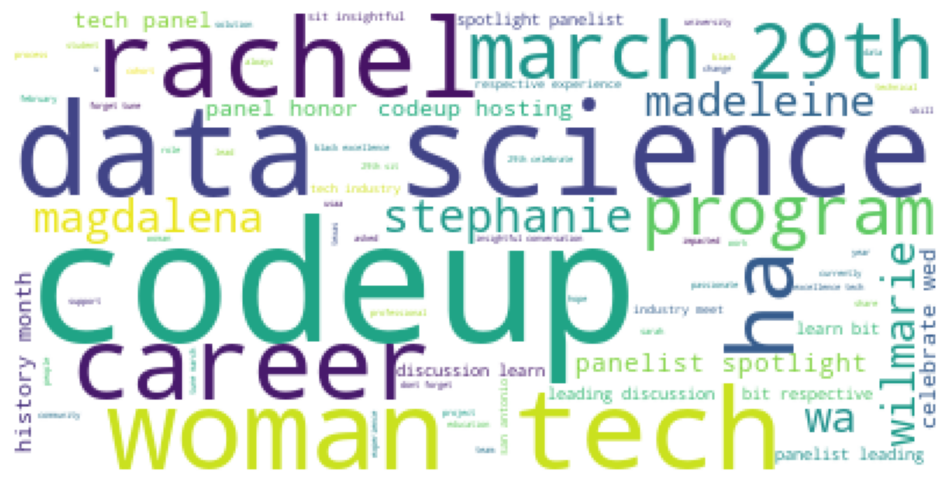

In [30]:
all_cloud3 = WordCloud(background_color='white').generate(' '.join(article))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud3)
plt.axis('off')
plt.show()

In [31]:
#assign to a variable
word_freq = pd.Series(article).value_counts()

In [32]:
#our top 5 words in the blogs are
word_freq.head()

codeup     26
tech       19
data       18
woman      16
science    15
Name: count, dtype: int64

Text(0, 0.5, 'Word')

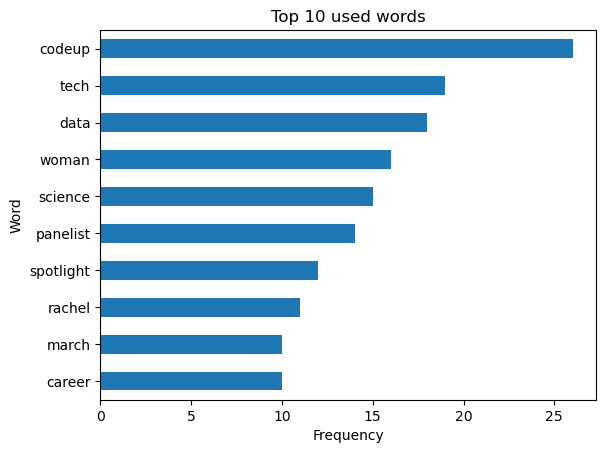

In [33]:
#visualize top 10
word_freq.head(10).plot.barh().invert_yaxis()

plt.title('Top 10 used words')
plt.xlabel('Frequency')
plt.ylabel('Word')

In [34]:
#put list of two word combos together
bgc =list(nltk.bigrams(article))
bgc

[('woman', 'tech'),
 ('tech', 'panelist'),
 ('panelist', 'spotlight'),
 ('spotlight', 'magdalena'),
 ('magdalena', 'rahn'),
 ('rahn', 'codeup'),
 ('codeup', 'hosting'),
 ('hosting', 'woman'),
 ('woman', 'tech'),
 ('tech', 'panel'),
 ('panel', 'honor'),
 ('honor', 'woman'),
 ('woman', 'history'),
 ('history', 'month'),
 ('month', 'march'),
 ('march', '29th'),
 ('29th', '2023'),
 ('2023', 'celebrate'),
 ('celebrate', 'wed'),
 ('wed', 'like'),
 ('like', 'spotlight'),
 ('spotlight', 'panelist'),
 ('panelist', 'leading'),
 ('leading', 'discussion'),
 ('discussion', 'learn'),
 ('learn', 'bit'),
 ('bit', 'respective'),
 ('respective', 'experience'),
 ('experience', 'woman'),
 ('woman', 'tech'),
 ('tech', 'industry'),
 ('industry', 'meet'),
 ('meet', 'magdalena'),
 ('magdalena', 'magdalena'),
 ('magdalena', 'rahn'),
 ('rahn', 'current'),
 ('current', 'codeup'),
 ('codeup', 'student'),
 ('student', 'data'),
 ('data', 'science'),
 ('science', 'cohort'),
 ('cohort', 'san'),
 ('san', 'antonio'),
 

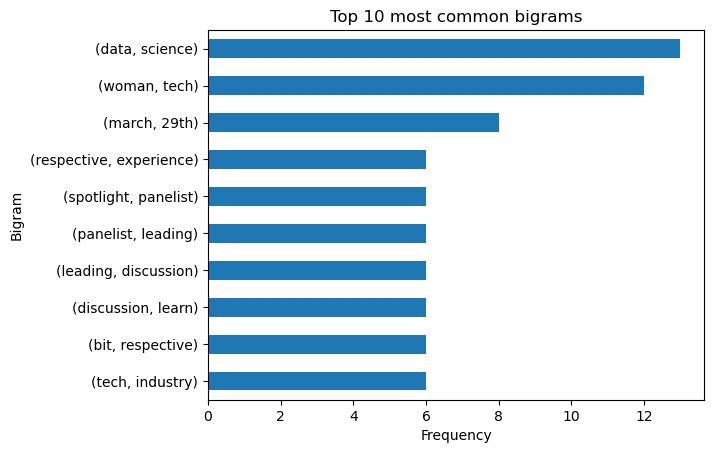

In [35]:
#visualize top ten
pd.Series(nltk.bigrams(article)).value_counts().head(10).plot.barh().invert_yaxis()
plt.title('Top 10 most common bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
None

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [36]:
#Test my function!
topics = ['business', 'sports', 'technology', 'entertainment']

news_df = pd.DataFrame(ac.get_news_articles(topics))
news_df.head()

,category,title,content
0,business,Ratan Tata must check whether his donations re...,"Wrestler Vinesh Phogat on Wednesday said, ""I r..."
1,business,I was laid off from LinkedIn before even start...,"Lea Schuhmacher, a woman who signed the contra..."
2,business,"India's high streets for shopping ranked, Beng...",Bengaluru's MG Road ranked first in the list o...
3,business,PepsiCo bottler Varun Beverages enters ₹1 lakh...,"Varun Beverages, PepsiCo's India franchise bot..."
4,business,All eyes on India as it becomes a 'plus 1' to ...,Vedanta Resources Chairman Anil Agarwal said a...


In [37]:
#applying clean function to get all normalized text in content column
all_words = clean(' '.join(news_df.content))
all_words

['wrestler',
 'vinesh',
 'phogat',
 'wednesday',
 'said',
 'request',
 'ratan',
 'tata',
 'check',
 'whether',
 'fund',
 'donates',
 'wrestling',
 'federation',
 'reach',
 'athlete',
 'added',
 'must',
 'seek',
 'information',
 'wrestling',
 'federation',
 'india',
 'wfi',
 'vinesh',
 'one',
 'many',
 'wrestler',
 'protesting',
 'delhi',
 'jantar',
 'mantar',
 'wfi',
 'chief',
 'brij',
 'bhushan',
 'sharan',
 'singh',
 'lea',
 'schuhmacher',
 'woman',
 'signed',
 'contract',
 'fulltime',
 'job',
 'linkedin',
 'september',
 '2022',
 'wa',
 'among',
 '700',
 'people',
 'laid',
 'microsoftowned',
 'company',
 'laid',
 'even',
 'starting',
 'job',
 'welcome',
 'many',
 'others',
 'world',
 'wrote',
 'nowviral',
 'linkedin',
 'post',
 'linkedin',
 'say',
 'least',
 'im',
 'disappointed',
 'added',
 'bengalurus',
 'mg',
 'road',
 'ranked',
 'first',
 'list',
 'india',
 'top',
 '30',
 'high',
 'street',
 'shopping',
 'according',
 'knight',
 'frank',
 'india',
 'think',
 'india',
 'think',
 '

In [38]:
#assign to a variable
news_freq = pd.Series(all_words).value_counts()
news_freq.head()


said     72
wa       49
ha       35
added    34
india    21
Name: count, dtype: int64

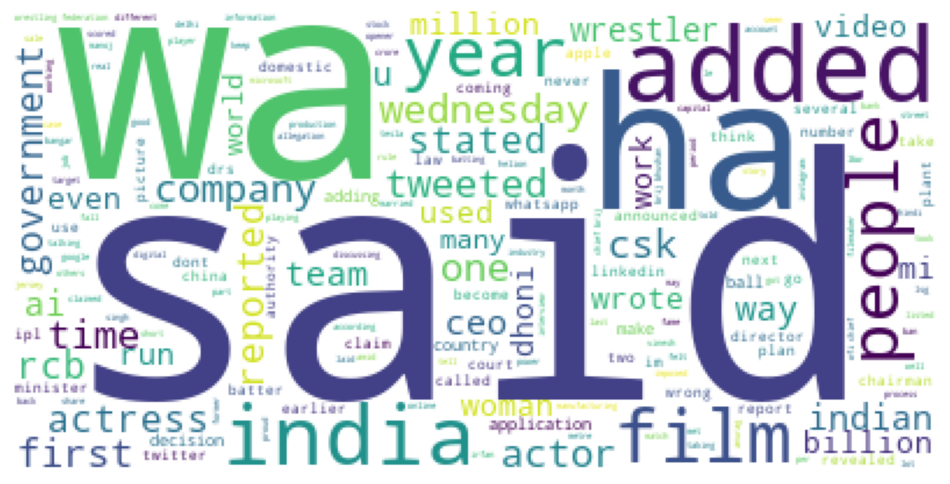

In [39]:
all_cloud4 = WordCloud(background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud4)
plt.axis('off')
plt.show()

Text(0, 0.5, 'Word')

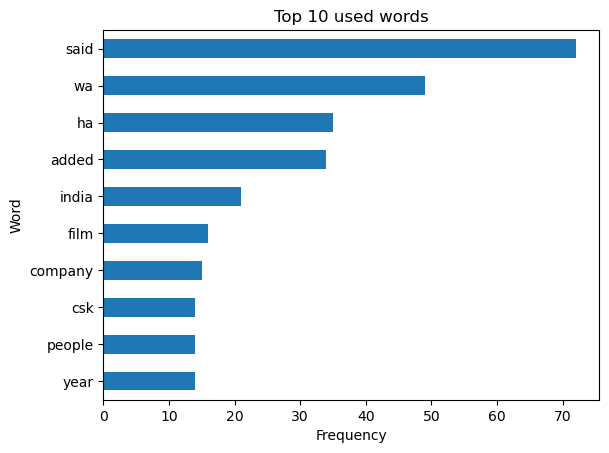

In [40]:
#visualize top 10
news_freq.head(10).plot.barh().invert_yaxis()

plt.title('Top 10 used words')
plt.xlabel('Frequency')
plt.ylabel('Word')